### Build a distribution of trap detuning

In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt
from tqdm import tqdm
M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules(1000, temp, detuning_sigma=1000)

### Check trap detuning distribution

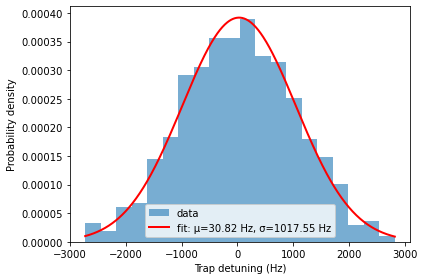

Mean = 30.820 Hz
Sigma = 1017.547 Hz


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Extract detuning column (Hz)
data = mol_0[:, -1].get()

# Fit Gaussian to raw data
mu, sigma = norm.fit(data)

# Plot histogram (normalized) + fitted Gaussian
plt.hist(data, bins=20, density=True, alpha=0.6, label="data")

x = np.linspace(data.min(), data.max(), 500)
plt.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=2,
         label=f"fit: μ={mu:.2f} Hz, σ={sigma:.2f} Hz")

plt.xlabel("Trap detuning (Hz)")
plt.ylabel("Probability density")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Mean = {mu:.3f} Hz")
print(f"Sigma = {sigma:.3f} Hz")


### RST varying trap detuning and compare

In [2]:
zt_freqs = cp.linspace(-60e3, 60e3, 1000)
zt_rabi = 1.01e3
zt_pulse = 500e-6
print(zt_rabi * zt_pulse)

trap_dets = np.linspace(-2e3, 2e3, 5)
mol_0 = cr.build_thermal_molecules(1000, [25e-6, 25e-6, 25e-6])
fractions = []
for det in trap_dets:
    frequencys, pol = cr.raman_sideband_thermometry(
        molecules_dev=mol_0,
        axis=2,
        frequencys=zt_freqs,
        rabi_freq=zt_rabi,
        pulse_time=zt_pulse,
        res=res,
        k_max=2,
        trap_detuning=(0, 0, det)
    )
    fractions.append(pol)

0.505


Raman thermometry: 100%|██████████| 1000/1000 [00:16<00:00, 61.77it/s]


In [4]:
mol_0 = cr.build_thermal_molecules(1000, [25e-6, 25e-6, 25e-6])
trap_dets = np.linspace(-2e3, 2e3, 5)
fractions_2 = []
for det in trap_dets:
    mol_0[:, 6] = cp.asarray(det, dtype=mol_0.dtype)
    frequencys, pol = cr.raman_sideband_thermometry(
        molecules_dev=mol_0,
        axis=2,
        frequencys=zt_freqs,
        rabi_freq=zt_rabi,
        pulse_time=zt_pulse,
        res=res,
        k_max=2,
        trap_detuning=(0, 0, 0)
    )
    fractions_2.append(pol)

Raman thermometry: 100%|██████████| 1000/1000 [00:14<00:00, 67.08it/s]


Text(0.5, 0, 'Frequency (kHz)')

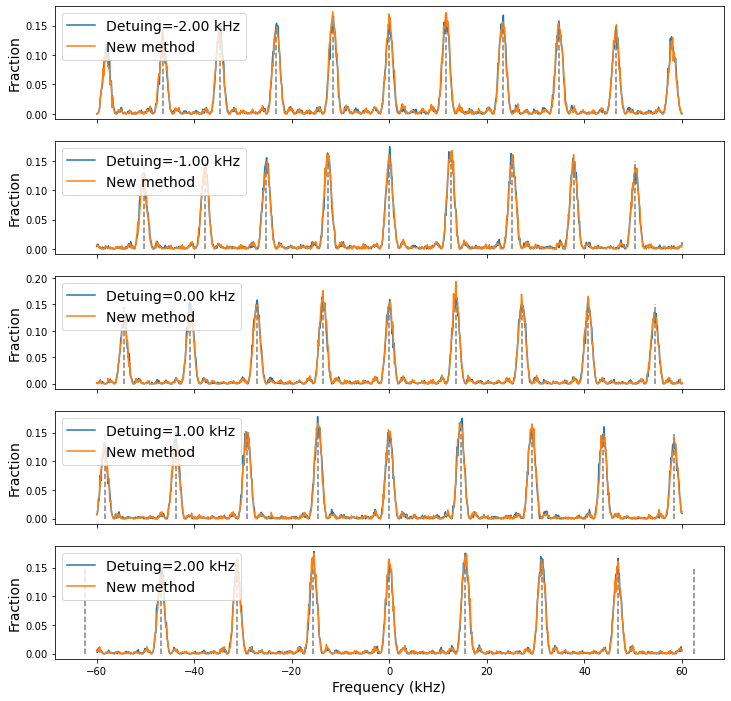

In [5]:
fig, ax = plt.subplots(5, 1, figsize=(12, 12), sharex=True)
for i, det in enumerate(trap_dets):
    ax[i].plot(frequencys.get()/1000, fractions[i].get()/1000, label=f"Detuing={det/1e3:.2f} kHz")
    ax[i].plot(frequencys.get()/1000, fractions_2[i].get()/1000, label=f"New method")
    ax[i].legend(fontsize=14)
    ax[i].set_ylabel("Fraction", fontsize=14)
    ax[i].vlines(np.linspace(-4, 4, 9)*((res.trap_freq[2].get())*1e-3/2/np.pi + det/1e3), 
                 0, 0.15, linestyle='--', color='gray')
ax[-1].set_xlabel("Frequency (kHz)", fontsize=14)

### RST with trap detuning distribution

In [ ]:
seq_partial = np.load("../partial_cooling_amp/seq_partial.npy")

zt_freqs = cp.linspace(-60e3, 60e3, 1000)
zt_rabi = 1.01e3
zt_pulse = 500e-6

temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules(1000, temp, detuning_sigma=0)

frequencys, polarizations = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2
)

mol_0 = cr.build_thermal_molecules(1000, temp, detuning_sigma=1000)


frequencys, polarizations_2 = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2
)

Raman thermometry: 100%|██████████| 1000/1000 [00:16<00:00, 58.84it/s]


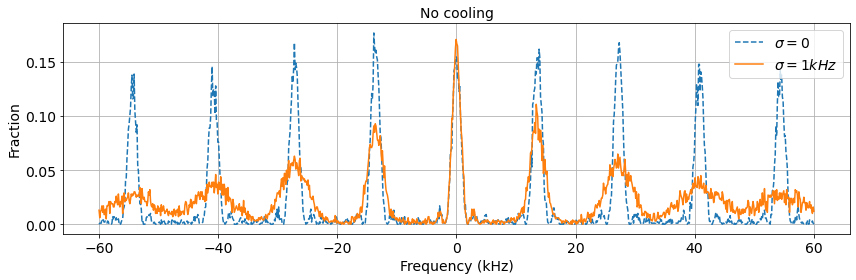

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4), sharex=True)
ax.plot(frequencys.get()/1e3, polarizations.get()/1000, '--', label='$\sigma=0$')
ax.plot(frequencys.get()/1e3, polarizations_2.get()/1000, label='$\sigma=1kHz$')
ax.grid()
ax.set_xlabel("Frequency (kHz)", fontsize=14)
ax.set_ylabel("Fraction", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title("No cooling", fontsize=14)
ax.legend(fontsize=14)
fig.tight_layout()

In [12]:
seq_partial = np.load("../partial_cooling_amp/seq_partial.npy")

zt_freqs = cp.linspace(-60e3, 60e3, 1000)
zt_rabi = 1.01e3
zt_pulse = 500e-6

temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules(1000, temp, detuning_sigma=0)
cr.raman_cool_with_pumping(
    mol_0,
    seq_partial,
    res
)
frequencys, polarizations = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2
)

Raman thermometry: 100%|██████████| 1000/1000 [00:16<00:00, 60.66it/s]


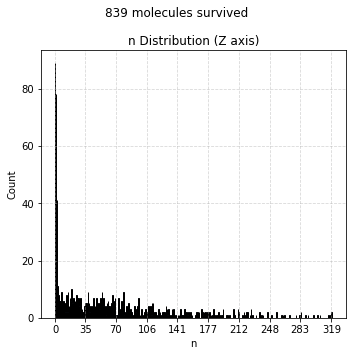

{'survival_rate_mean': array(0.839),
 'survival_rate_sem': array(0.00036678),
 'mot_mean': array([ 0.22526818,  0.63051251, 63.15256257]),
 'mot_sem': array([0.00126909, 0.00387114, 0.07698358]),
 'ground_state_rate_mean': array(0.08603239),
 'ground_state_rate_sem': array(0.00027435),
 'N': array(1000),
 'B': array(1000)}

In [11]:
dist = cr.get_n_distribution_gpu(mol_0, max_bins=10, plot=(False, False, True))
result = cr.bootstrap_stats_from_molecules(mol_0)
result

In [18]:
seq_partial = np.load("../partial_cooling_amp/seq_partial.npy")

zt_freqs = cp.linspace(-60e3, 60e3, 1000)
zt_rabi = 1.01e3
zt_pulse = 500e-6

temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules(1000, temp, detuning_sigma=1000)
cr.raman_cool_with_pumping(
    mol_0,
    seq_partial,
    res
)
frequencys, polarizations_2 = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2
)

Raman thermometry: 100%|██████████| 1000/1000 [00:16<00:00, 59.26it/s]


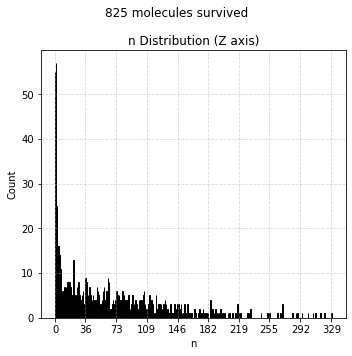

{'survival_rate_mean': array(0.825),
 'survival_rate_sem': array(0.00038128),
 'mot_mean': array([ 0.17454545,  0.53090909, 65.09090909]),
 'mot_sem': array([0.00144707, 0.00388434, 0.07533629]),
 'ground_state_rate_mean': array(0.05193483),
 'ground_state_rate_sem': array(0.00022393),
 'N': array(1000),
 'B': array(1000)}

In [19]:
dist = cr.get_n_distribution_gpu(mol_0, max_bins=10, plot=(False, False, True))
result = cr.bootstrap_stats_from_molecules(mol_0)
result

In [20]:
import json
payload = {
    "axes": ["x", "y", "z"],
    "counts": [{str(k): int(v) for k, v in d.items()} for d in dist],
}

with open("dist_partial.json", "w") as f:
    json.dump(payload, f, indent=2)

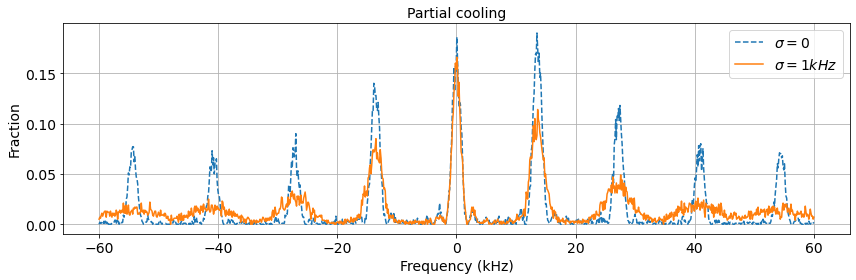

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4), sharex=True)
ax.plot(frequencys.get()/1e3, polarizations.get()/1000, '--', label='$\sigma=0$')
ax.plot(frequencys.get()/1e3, polarizations_2.get()/1000, label='$\sigma=1kHz$')
ax.grid()
ax.set_xlabel("Frequency (kHz)", fontsize=14)
ax.set_ylabel("Fraction", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title("Partial cooling", fontsize=14)
ax.legend(fontsize=14)
fig.tight_layout()

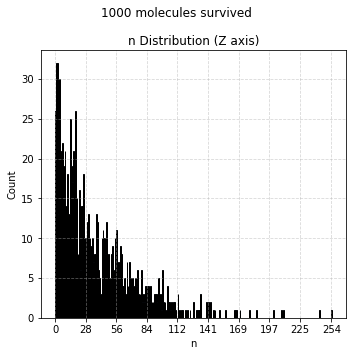

{'survival_rate_mean': array(1.),
 'survival_rate_sem': array(0.),
 'mot_mean': array([ 6.222,  7.758, 37.685]),
 'mot_sem': array([0.00685893, 0.00761321, 0.03713828]),
 'ground_state_rate_mean': array(0.001),
 'ground_state_rate_sem': array(3.18582949e-05),
 'N': array(1000),
 'B': array(1000)}

In [15]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules(1000, temp, detuning_sigma=0)
dist = cr.get_n_distribution_gpu(mol_0, max_bins=10, plot=(False, False, True))
result = cr.bootstrap_stats_from_molecules(mol_0)
result

In [17]:
import json
payload = {
    "axes": ["x", "y", "z"],
    "counts": [{str(k): int(v) for k, v in d.items()} for d in dist],
}

with open("dist_thermal.json", "w") as f:
    json.dump(payload, f, indent=2)

### 1 kHz trap detuning

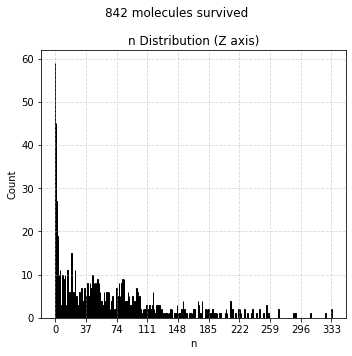

{'survival_rate_mean': array(0.842),
 'survival_rate_sem': array(0.00036762),
 'mot_mean': array([ 0.15914489,  0.45486936, 63.39904988]),
 'mot_sem': array([0.00117472, 0.00313361, 0.07128216]),
 'ground_state_rate_mean': array(0.05656566),
 'ground_state_rate_sem': array(0.0002393),
 'N': array(1000),
 'B': array(1000)}

In [4]:
seq_partial = np.load("../partial_cooling_amp/seq_partial.npy")

mol = cr.build_thermal_molecules(1000, [25e-6, 25e-6, 25e-6])
cr.raman_cool_with_pumping(
    mol,
    seq_partial,
    res,
    trap_detuning=(0, 0, 1e3)
)
dist = cr.get_n_distribution_gpu(mol, plot=(False, False, True), max_bins=10)
result = cr.bootstrap_stats_from_molecules(mol)
result

### No trap detuning

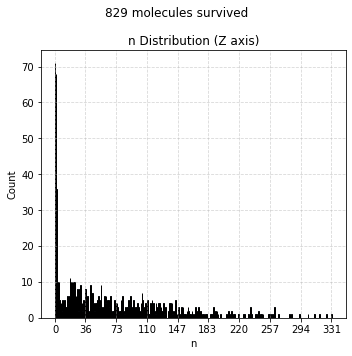

{'survival_rate_mean': array(0.829),
 'survival_rate_sem': array(0.00038263),
 'mot_mean': array([ 0.22074789,  0.38359469, 65.12183353]),
 'mot_sem': array([0.00152201, 0.00274436, 0.07462126]),
 'ground_state_rate_mean': array(0.06646217),
 'ground_state_rate_sem': array(0.00025787),
 'N': array(1000),
 'B': array(1000)}

In [5]:
seq_partial = np.load("../partial_cooling_amp/seq_partial.npy")

mol = cr.build_thermal_molecules(1000, [25e-6, 25e-6, 25e-6])
cr.raman_cool_with_pumping(
    mol,
    seq_partial,
    res,
    trap_detuning=(0, 0, 0)
)
dist = cr.get_n_distribution_gpu(mol, plot=(False, False, True), max_bins=10)
result = cr.bootstrap_stats_from_molecules(mol)
result

### Optimize with mean

In [24]:
seq_partial = np.load("../../op_for_mean/omega_time_ga_runs/OmegaTimeGA_20260203_153318/gen_001/best_sequence.npy")

zt_freqs = cp.linspace(-60e3, 60e3, 1000)
zt_rabi = 1.01e3
zt_pulse = 500e-6

temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules(1000, temp, detuning_sigma=0)
cr.raman_cool_with_pumping(
    mol_0,
    seq_partial,
    res
)
frequencys, polarizations = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2
)

Raman thermometry: 100%|██████████| 1000/1000 [00:16<00:00, 59.87it/s]


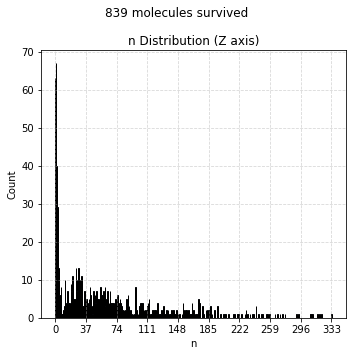

{'survival_rate_mean': array(0.839),
 'survival_rate_sem': array(0.00036423),
 'mot_mean': array([ 0.15375447,  0.38140644, 61.28605483]),
 'mot_sem': array([0.00082286, 0.00251448, 0.0702843 ]),
 'ground_state_rate_mean': array(0.0610998),
 'ground_state_rate_sem': array(0.00024032),
 'N': array(1000),
 'B': array(1000)}

In [25]:
dist = cr.get_n_distribution_gpu(mol_0, max_bins=10, plot=(False, False, True))
result = cr.bootstrap_stats_from_molecules(mol_0)
result